In [1]:
#Importing necessary libraries

# Seed value
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications.densenet import DenseNet201

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
images_path = '/kaggle/input/plant-pathology-2020-fgvc7/images'
train_path = '/kaggle/input/plant-pathology-2020-fgvc7/train.csv'
test_path = '/kaggle/input/plant-pathology-2020-fgvc7/test.csv'
sub_path = '/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv'

In [3]:
#Reading the csv files to a pandas dataframe
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
print(train.shape)
print(test.shape)

(1821, 5)
(1821, 1)


In [5]:
print(train.head())
print(test.head())

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
  image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4


#### Checking the count of 0 and 1 for each class in train dataset[](http://)

After looking at the training dataset it is very clear that there is class imbalance in the dataset. There are only **91** images for class **multiple diseases** whereas there are 516, 622 and 592 images for classes healthy, rust and scab.

In [6]:
target_multi_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

print("Multi Classification Targets")
print(train[target_multi_cols].sum())

Multi Classification Targets
healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64


### Loading Images.....

In [7]:
ex_img = os.path.join(images_path, train.image_id[0] + '.jpg')
ex_img = cv2.imread(ex_img)
print('Shape of original images: {}'.format(ex_img.shape))

Shape of original images: (1365, 2048, 3)


### Image Processing

#### Displaying some images in training set

When the image file is read with the OpenCV function imread(), the order of color is BGR. 

**First four images in the training set**

In [8]:
imgs = [id for id in train.image_id[:4]]
print(imgs)

['Train_0', 'Train_1', 'Train_2', 'Train_3']


**Class for the first four images in training set**

In [9]:
titles = train[['healthy','multiple_diseases','rust','scab']].idxmax(axis = 1)[:4].to_list()
print(titles)

['scab', 'multiple_diseases', 'healthy', 'rust']


**Displaying the first four images in the training set**

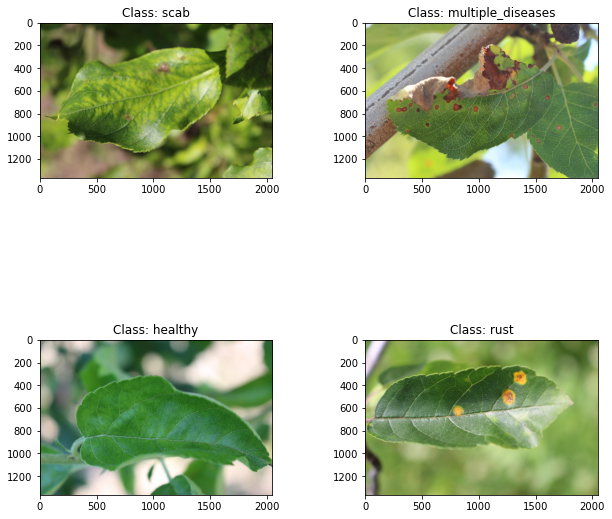

In [10]:
fig = plt.figure(figsize =(10,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(1,5):
    ax = fig.add_subplot(2,2,i)
    img = cv2.cvtColor(cv2.imread(os.path.join(images_path,imgs[i-1]+'.jpg')),
                       cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title('Class: {}'.format(titles[i-1]))
plt.show()

**Displaying the images only in red channel**

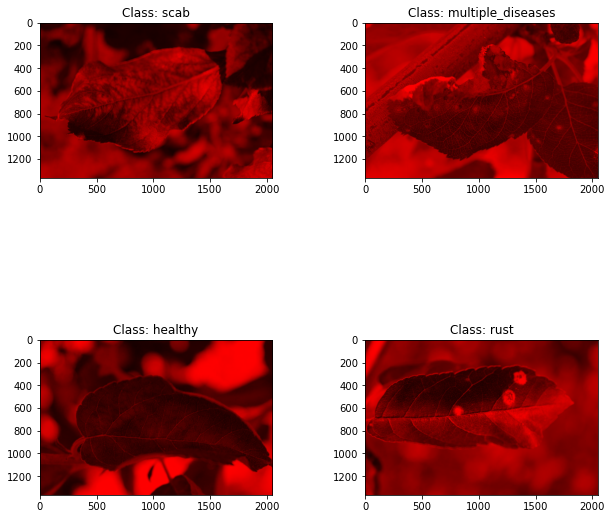

In [11]:
fig = plt.figure(figsize =(10,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(1,5):
    ax = fig.add_subplot(2,2,i)
    img = cv2.cvtColor(cv2.imread(os.path.join(images_path,imgs[i-1]+'.jpg')),
                       cv2.COLOR_BGR2RGB)
    img[:,:,1] = 0 #Setting green channel to 0
    img[:,:,2] = 0 #Setting blue channel to 0
    ax.imshow(img)
    ax.set_title('Class: {}'.format(titles[i-1]))
plt.show()

**Displaying the images only in green channel**

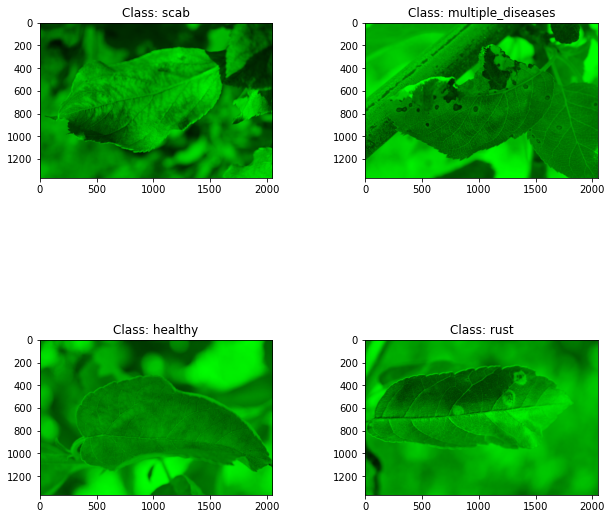

In [12]:
fig = plt.figure(figsize =(10,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(1,5):
    ax = fig.add_subplot(2,2,i)
    img = cv2.cvtColor(cv2.imread(os.path.join(images_path,imgs[i-1]+'.jpg')),
                       cv2.COLOR_BGR2RGB)
    img[:,:,0] = 0 #Setting red channel to 0
    img[:,:,2] = 0 #Setting blue channel to 0
    ax.imshow(img)
    ax.set_title('Class: {}'.format(titles[i-1]))
plt.show()

**Displaying the images only in blue channel**

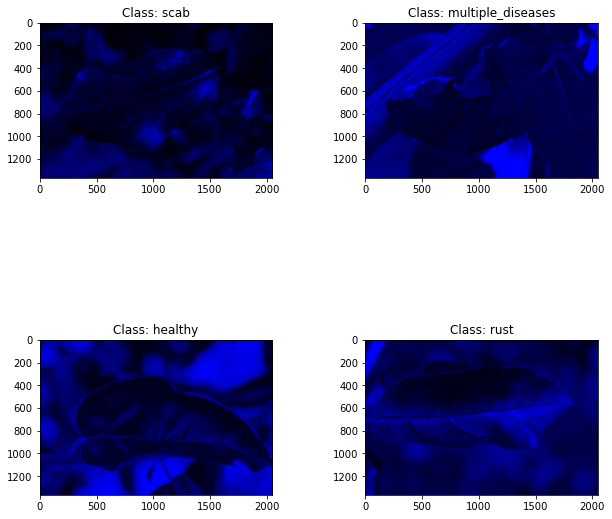

In [13]:
fig = plt.figure(figsize =(10,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(1,5):
    ax = fig.add_subplot(2,2,i)
    img = cv2.cvtColor(cv2.imread(os.path.join(images_path,imgs[i-1]+'.jpg')),
                       cv2.COLOR_BGR2RGB)
    img[:,:,0] = 0 #Setting red channel to 0
    img[:,:,1] = 0 #Setting green channel to 0
    ax.imshow(img)
    ax.set_title('Class: {}'.format(titles[i-1]))
plt.show()

**Displaying the images in greyscale mode**

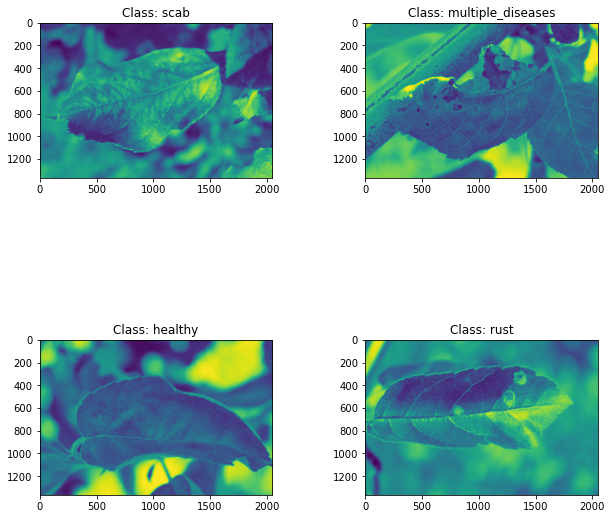

In [14]:
fig = plt.figure(figsize =(10,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(1,5):
    ax = fig.add_subplot(2,2,i)
    img = cv2.cvtColor(cv2.imread(os.path.join(images_path,imgs[i-1]+'.jpg')),
                       cv2.COLOR_BGR2GRAY)
    ax.imshow(img)
    ax.set_title('Class: {}'.format(titles[i-1]))
plt.show()

**Displaying images in test set**

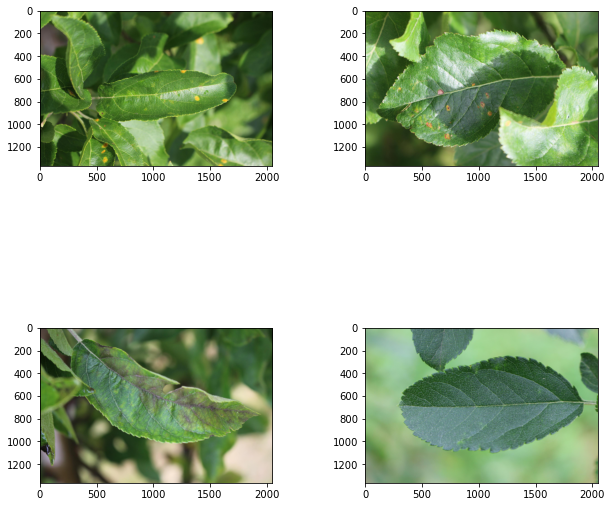

In [15]:
fig = plt.figure(figsize =(10,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(1,5):
    ax = fig.add_subplot(2,2,i)
    img = cv2.cvtColor(cv2.imread(os.path.join(images_path,test.image_id[i-1] + '.jpg')),
                       cv2.COLOR_BGR2RGB)
    ax.imshow(img)
plt.show()

#### Handling Imbalance in the dataset

To handle the imbalance in the dataset I have used RandomOverSampler - which will increase the images for minority class i.e. **multiple_dieases**.

In [16]:
train['image_name'] = train['image_id'].astype(str) + '.jpg'
train.head()

,image_id,healthy,multiple_diseases,rust,scab,image_name
0,Train_0,0,0,0,1,Train_0.jpg
1,Train_1,0,1,0,0,Train_1.jpg
2,Train_2,1,0,0,0,Train_2.jpg
3,Train_3,0,0,1,0,Train_3.jpg
4,Train_4,1,0,0,0,Train_4.jpg


In [17]:
def balance_set(df, x_cols, y_cols):
    ros = RandomOverSampler(random_state=42)

    x_multi, y_multi = ros.fit_resample(df[x_cols], df[y_cols].values)
    data = pd.concat([x_multi, pd.DataFrame(y_multi, columns= y_cols)], axis=1)
    return data

train_df = balance_set(train, 
                          x_cols = ["image_id", "image_name"],
                          y_cols = target_multi_cols)


print("Multi Classification Labels")
print(train_df[target_multi_cols].sum())

Multi Classification Labels
healthy              622
multiple_diseases    622
rust                 622
scab                 622
dtype: int64


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [18]:
#Creating a dataframe for training
train_df['label'] = train_df[['healthy','multiple_diseases','rust','scab']].idxmax(axis = 1)
train_df.head()

,image_id,image_name,healthy,multiple_diseases,rust,scab,label
0,Train_0,Train_0.jpg,0,0,0,1,scab
1,Train_1,Train_1.jpg,0,1,0,0,multiple_diseases
2,Train_2,Train_2.jpg,1,0,0,0,healthy
3,Train_3,Train_3.jpg,0,0,1,0,rust
4,Train_4,Train_4.jpg,1,0,0,0,healthy


### Configure GPU for Deep Learning

In [19]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
if len(gpus) == 1 : 
    strategy = tf.distribute.OneDeviceStrategy(device = "/gpu:0")
else:
    strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision" : True})
print("Mixed precision enabled")

Mixed precision enabled


### Image Data Generator

In [21]:
#Gaussian blurring
def filtering(img):
    return cv2.GaussianBlur(img,(5,5),0)

In [22]:
datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True,
                             vertical_flip = True, rotation_range = 180,
                             validation_split = 0.2, preprocessing_function = filtering)

train_generator = datagen.flow_from_dataframe(train_df,images_path, 
                                              y_col = 'label', x_col = 'image_name',
                                              target_size=(256, 256), class_mode = 'categorical',
                                              batch_size=32, shuffle = True,
                                              subset ='training')

valid_generator = datagen.flow_from_dataframe(train_df,images_path, 
                                              y_col = 'label', x_col = 'image_name',
                                              target_size=(256, 256), class_mode = 'categorical',
                                              batch_size=32, shuffle = True,
                                              subset ='validation')

Found 1991 validated image filenames belonging to 4 classes.
Found 497 validated image filenames belonging to 4 classes.


In [23]:
# learning rate decay
learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0003, 
                                                                         decay_steps=2, 
                                                                         decay_rate=0.97, 
                                                                         staircase=False)
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        self.patience = 3
        self.best = 0
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        if np.greater(logs["val_accuracy"], self.best):
            self.wait = 0
            self.best = logs["val_accuracy"]
        else:
            self.wait +=1
            if self.wait >= self.patience:
                print(f"Stopping Training. Validation accuracy hasn't improved >= {self.patience} times")
                self.model.stop_training=True

### Model

### Transfer learning with fine tuning

- Transfer learning is the practice of using a model, and weights that was trained on a different task and applying it to a new  task. The idea is to take advantage of what the model learned on the original task and to "transfer" this to the current   task.

- This is achieved by reusing part of the original model's architechre and only changing the last few layers - typically the dense layers. 

- I have used transfer learning with **fine-tuning**, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

- I have tried different models such as ResNet, EfficientNet and VGG 16 with both techniques and I found that the best performing model is **DenseNet with fine tuning**. The results may vary.

In [24]:
def plot_loss_accuracy(history):
    
    fig, axs = plt.subplots(1,2, figsize=(12, 5))
    hist = history.history
    for ax, metric in zip(axs, ["loss", "accuracy"]):
        ax.plot(hist[metric],label = 'train')
        ax.plot(hist["val_"+metric], label = 'val')
        ax.legend()
        ax.set_xlabel('epochs')
        ax.set_ylabel(metric)

#### Densenet

In [25]:
def dense_model(trainable_weights = False):
    
    tf.keras.backend.clear_session()
    
    dense_net = DenseNet201(input_shape=(256, 256, 3), weights="imagenet", include_top=False)
    
    for layer in dense_net.layers:
        layer.trainable=trainable_weights
    
    model = tf.keras.models.Sequential([dense_net,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(128, activation='relu'),
                                        tf.keras.layers.Dense(64,  activation= 'relu'),
                                        tf.keras.layers.Dropout(0.3),
                                        tf.keras.layers.Dense(4, activation='softmax')
                                ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return model

**Unfreezing the layers in Denset using layer.trainabe = True**

In [26]:
with tf.device("/device:GPU:0"):
    model = dense_model(trainable_weights=True)

    history = model.fit(train_generator, validation_data= valid_generator, 
                        batch_size = 32, epochs = 25,
                        callbacks = [EarlyStoppingCallback()],
                        steps_per_epoch=32)

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/25
32/32 [==============================] - 112s 3s/step - loss: 1.1267 - accuracy: 0.4887 - val_loss: 1.1241 - val_accuracy: 0.5875
Epoch 2/25
32/32 [==============================] - 79s 2s/step - loss: 0.4214 - accuracy: 0.8535 - val_loss: 0.8472 - val_accuracy: 0.6922
Epoch 3/25
32/32 [==============================] - 75s 2s/step - loss: 0.2791 - accuracy: 0.9011 - val_loss: 0.5252 - val_accuracy: 0.8169
Epoch 4/25
32/32 [==============================] - 75s 2s/step - loss: 0.1602 - accuracy: 0.9496 - val_loss: 0.3354 - val_accuracy: 0.8773
Epoch 5/25
32/32 [==============================] - 76s 2s/step - loss: 0.1830 - accuracy: 0.9362 - val_loss: 0.2829 - val_accuracy: 0.8994
Epoch 6/25
32/32 [==============================] - 74s 2s/step - loss: 0.1387 - accuracy: 0.9567 - val_loss: 0.2693 - val_accuracy: 0.9054
Epoch 7/25
32/32 [==============================] - 74s 2s/step - loss: 0.1351 - accuracy: 0.9

In [27]:
# To save the model in the working directory
# dense_net.save('../../DenseNet_unfreeze.h5')

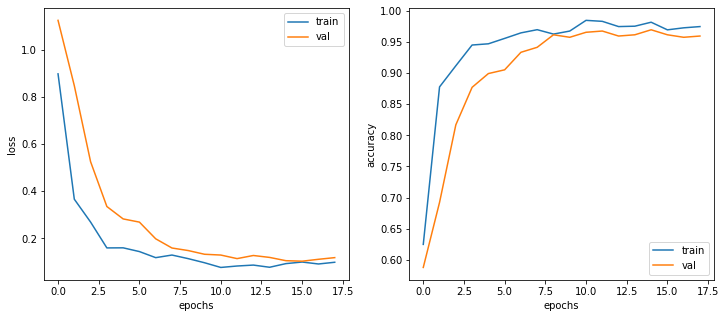

In [28]:
plot_loss_accuracy(history)

### Predicting on test images

In [29]:
#Creating a dataframe for testing
test['image_name'] = test['image_id'].astype(str) + '.jpg'
test.head()

,image_id,image_name
0,Test_0,Test_0.jpg
1,Test_1,Test_1.jpg
2,Test_2,Test_2.jpg
3,Test_3,Test_3.jpg
4,Test_4,Test_4.jpg


In [30]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(test,images_path,
                                                  x_col="image_name",y_col=None,
                                                  target_size=(256, 256),class_mode=None,
                                                  batch_size=3,shuffle=False)

test_generator.reset()

filenames = test_generator.filenames
nb_samples = len(filenames)

Found 1821 validated image filenames.


In [31]:
# Predict labels on the test set
predict = model.predict(test_generator,steps = nb_samples)

In [32]:
sub = pd.read_csv(sub_path)
# Prepare the submission file
sub.loc[:, 'healthy':] = predict

In [33]:
sub.to_csv('submission_comp.csv', index=False)
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.001596,0.002695,0.995524,0.000185
1,Test_1,0.011931,0.002101,0.985679,0.000289
2,Test_2,0.024875,0.007829,0.001880,0.965415
3,Test_3,0.998857,0.000111,0.000946,0.000086
4,Test_4,0.000320,0.000637,0.999001,0.000043


After submitting this notebook to the **Plant Pathology 2020 - FGVC7 competition**, I have achieved an accuracy of ~94% (0.93885). I believe it can be further improved by using different architectures. 

It can be concluded that transfer Learning with fine tuning can be used to develop a system for our own dataset of wheat leaves. 